# Feature extraction from ambient seismic field


This tutorial will give examples on how to extract features from ambient field data. We will ue

In [55]:
import numpy as np
# import pandas as pd

# import warnings
# warnings.simplefilter("ignore")

# seismic packages
import obspy
from obspy.clients.fdsn.client import Client 
from obspy.geodetics.base import gps2dist_azimuth
client=Client("IRIS")


# plotting packages
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
# %matplotlib notebook

matplotlib.rc('font', size=12) 
matplotlib.rc('font', size=12) 

# scipy for seismic data processing
import scipy as sc
from scipy import signal


# feature extraction packages
import tsfel
import seis_feature     # this is a compilation


First, we will download noise data using obspy. Let's pick an interesting station for noise.

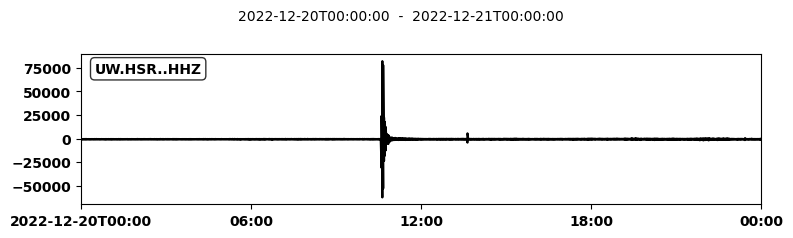

100.0


In [44]:
t0 = obspy.UTCDateTime("2022-12-20")
tr=client.get_waveforms(network="UW",station="HSR",channel="HHZ",location="*",starttime=t0,endtime=t0+86400,attach_response=True);
# tr.remove_response()
tr.plot() 
fs=tr[0].stats.sampling_rate
print(fs)
     

The data looks quite noisy with no apparent change in the amplitudes.  We will proceed with increasing complexity in the features.  
## 1. Fourier Transform

In [45]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = tr[0].stats.npts
## FFT the signals
# fill up until 2^N value to speed up the FFT
Nfft = next_fast_len(int(tr[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=tr[0].stats.delta)[:Nfft//2]
tr.taper(max_percentage=0.05)
Zhat = fft(tr[0].data,n=Nfft)#/np.sqrt(Z[0].stats.npts)

plotting

Text(0, 0.5, 'Velocity spectrum (m/s)')

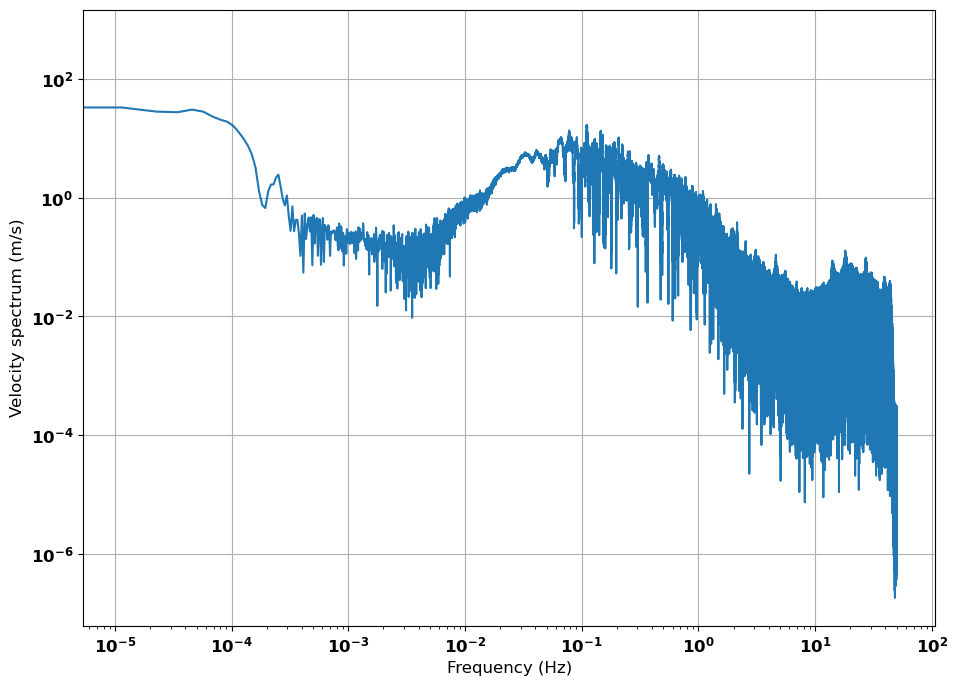

In [46]:
fig,ax=plt.subplots(1,1,figsize=(11,8))
ax.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax.grid(True)
ax.set_xscale('log');ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)');ax.set_ylabel('Velocity spectrum (m/s)')

## 2. Spectrogram

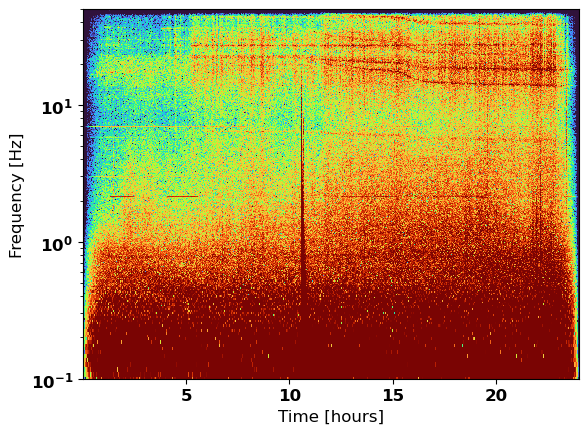

In [47]:
f, t, Sxx = signal.spectrogram(tr[0].data, fs = tr[0].stats.sampling_rate,nperseg=40*256)
plt.pcolormesh(t/3600, f,np.log10(Sxx),vmin=-2,vmax=3,cmap="turbo")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [hours]')
plt.yscale('log')
plt.ylim([0.1,50])
plt.show()

## 3. Features used in event detections

1. STA/LTA to detect earthquakes (at almost all seismic networks)
2. Kurtosis to detect earthquakes (at several seismic networks)

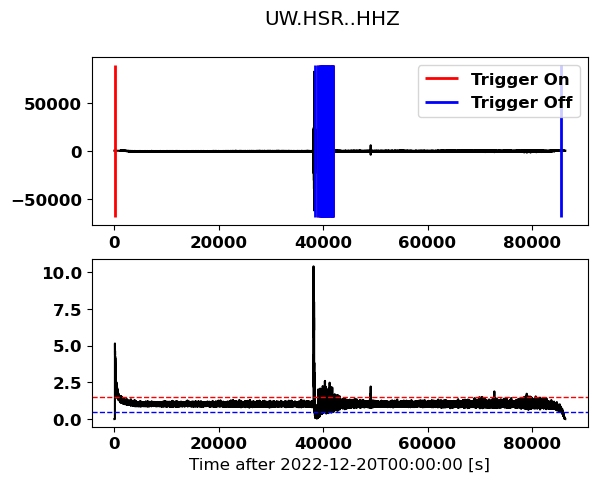

In [51]:
from obspy.signal.trigger import classic_sta_lta, plot_trigger, recursive_sta_lta

# short time scale:
sta = 5 # seconds
lta = 100 # seconds
cft = recursive_sta_lta(tr[0].data, int(sta * fs), int(lta * fs))
plot_trigger(tr[0], cft, 1.5, 0.5)

In [59]:
from obspy.realtime.signal import kurtosis
z=kurtosis(tr[0])
plt.plot(z)
plt.show()

<IPython.core.display.Javascript object>

## extract features using tsfel

TSFEL is an open-source package

In [65]:
cfg = tsfel.get_features_by_domain()
df = tsfel.time_series_features_extractor(cfg, tr[0].data[:100*100], fs= tr[0].stats.sampling_rate, window_size=len(tr[0].data)) 

*** Feature extraction started ***


SystemExit: Empty signal windows. Please check window size input parameter.